# Congressional Voting Data Set

Congressional Voting party based on different questions on specific topics.

_Source_: https://www.kaggle.com/competitions/184-702-tu-ml-ws-24-congressional-voting/data

Group 18 Members:

- Clara Pichler, 11917694
- Hannah Knapp, 11901857 
- Sibel Toprakkiran, 09426341

### Overview

1. Introduction
- Requirements & Dependencies
- Loading in the Data Set

2. Preprocessing

3. Classification
- SVM
- Random Forest
- Multilayer Perceptron

4. Analysis of Performance

## Introduction 

### Requirements & Dependencies

This project was created using Python 3.12.5 The exact versions of the dependencies can be installed with the following command.

In [73]:
%pip install -r requirements.txt -q
%pip install tpot
%pip install torch


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [74]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt


from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from tpot import TPOTClassifier
from tpot.config import classifier_config_dict

### Loading Data

In [75]:
df_voting = pd.read_csv('data/CongressionalVotingID.shuf.lrn.csv')
df_voting_test = pd.read_csv('data/CongressionalVotingID.shuf.tes.csv')

### Data Description

In [76]:
display(df_voting.head(5))
df_voting.info(verbose=True)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,democrat,y,n,y,n,y,y,y,n,y,y,n,n,y,y,n,unknown
1,86,democrat,n,n,y,n,y,y,n,n,n,y,y,y,y,y,n,y
2,264,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,unknown
3,258,republican,n,n,n,y,y,n,n,n,n,n,n,y,n,y,unknown,y
4,381,democrat,y,y,y,n,n,y,unknown,y,y,n,y,n,y,n,y,y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      218 non-null    int64 
 1   class                                   218 non-null    object
 2   handicapped-infants                     218 non-null    object
 3   water-project-cost-sharing              218 non-null    object
 4   adoption-of-the-budget-resolution       218 non-null    object
 5   physician-fee-freeze                    218 non-null    object
 6   el-salvador-aid                         218 non-null    object
 7   religious-groups-in-schools             218 non-null    object
 8   anti-satellite-test-ban                 218 non-null    object
 9   aid-to-nicaraguan-contras               218 non-null    object
 10  mx-missile                              218 non-null    object
 11  immigr

This data set has 218 entries and 18 attributes. The target value of this data set is class so what party the people are voting for in congress. We want in this classification task to predict based on the questions voters answered with either yes "y" or no "n". So the rest of the attributes are all binary data. There are no missing values per se but some questions were answered with unkown so we have to look how we want to deal with this missing values. 

Index(['ID', 'class', 'handicapped-infants', 'water-project-cost-sharing',
       'adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-aid', 'religious-groups-in-schools',
       'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-crporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports',
       'export-administration-act-south-africa'],
      dtype='object')

41.74311926605505

58.256880733944946

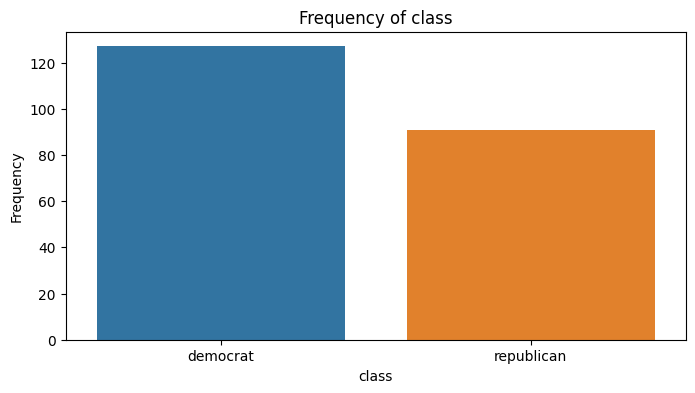

In [77]:
display(df_voting.columns)

display(len(df_voting[df_voting['class']=='republican'])/len(df_voting['class'])*100)
display(len(df_voting[df_voting['class']=='democrat'])/len(df_voting['class'])*100)

plt.figure(figsize=(8, 4))
sns.countplot(x='class', hue='class', data=df_voting)
plt.title('Frequency of class')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

From the frequency table we can see that there are more democrats than republicans in the data set.

handicapped-infants,n,unknown,y,All
class,,,,
democrat,41,3,83,127
republican,68,1,22,91
All,109,4,105,218


water-project-cost-sharing,n,unknown,y,All
class,,,,
democrat,57,15,55,127
republican,33,13,45,91
All,90,28,100,218


adoption-of-the-budget-resolution,n,unknown,y,All
class,,,,
democrat,8,6,113,127
republican,79,2,10,91
All,87,8,123,218


physician-fee-freeze,n,unknown,y,All
class,,,,
democrat,117,5,5,127
republican,2,1,88,91
All,119,6,93,218


el-salvador-aid,n,unknown,y,All
class,,,,
democrat,100,6,21,127
republican,4,1,86,91
All,104,7,107,218


religious-groups-in-schools,n,unknown,y,All
class,,,,
democrat,69,5,53,127
republican,7,1,83,91
All,76,6,136,218


anti-satellite-test-ban,n,unknown,y,All
class,,,,
democrat,25,4,98,127
republican,68,3,20,91
All,93,7,118,218


aid-to-nicaraguan-contras,n,unknown,y,All
class,,,,
democrat,17,3,107,127
republican,72,9,10,91
All,89,12,117,218


mx-missile,n,unknown,y,All
class,,,,
democrat,27,7,93,127
republican,80,1,10,91
All,107,8,103,218


immigration,n,unknown,y,All
class,,,,
democrat,71,2,54,127
republican,45,1,45,91
All,116,3,99,218


synfuels-crporation-cutback,n,unknown,y,All
class,,,,
democrat,61,6,60,127
republican,73,4,14,91
All,134,10,74,218


education-spending,n,unknown,y,All
class,,,,
democrat,103,11,13,127
republican,11,7,73,91
All,114,18,86,218


superfund-right-to-sue,n,unknown,y,All
class,,,,
democrat,83,8,36,127
republican,9,8,74,91
All,92,16,110,218


crime,n,unknown,y,All
class,,,,
democrat,82,5,40,127
republican,2,6,83,91
All,84,11,123,218


duty-free-exports,n,unknown,y,All
class,,,,
democrat,41,6,80,127
republican,75,8,8,91
All,116,14,88,218


export-administration-act-south-africa,n,unknown,y,All
class,,,,
democrat,4,41,82,127
republican,25,13,53,91
All,29,54,135,218


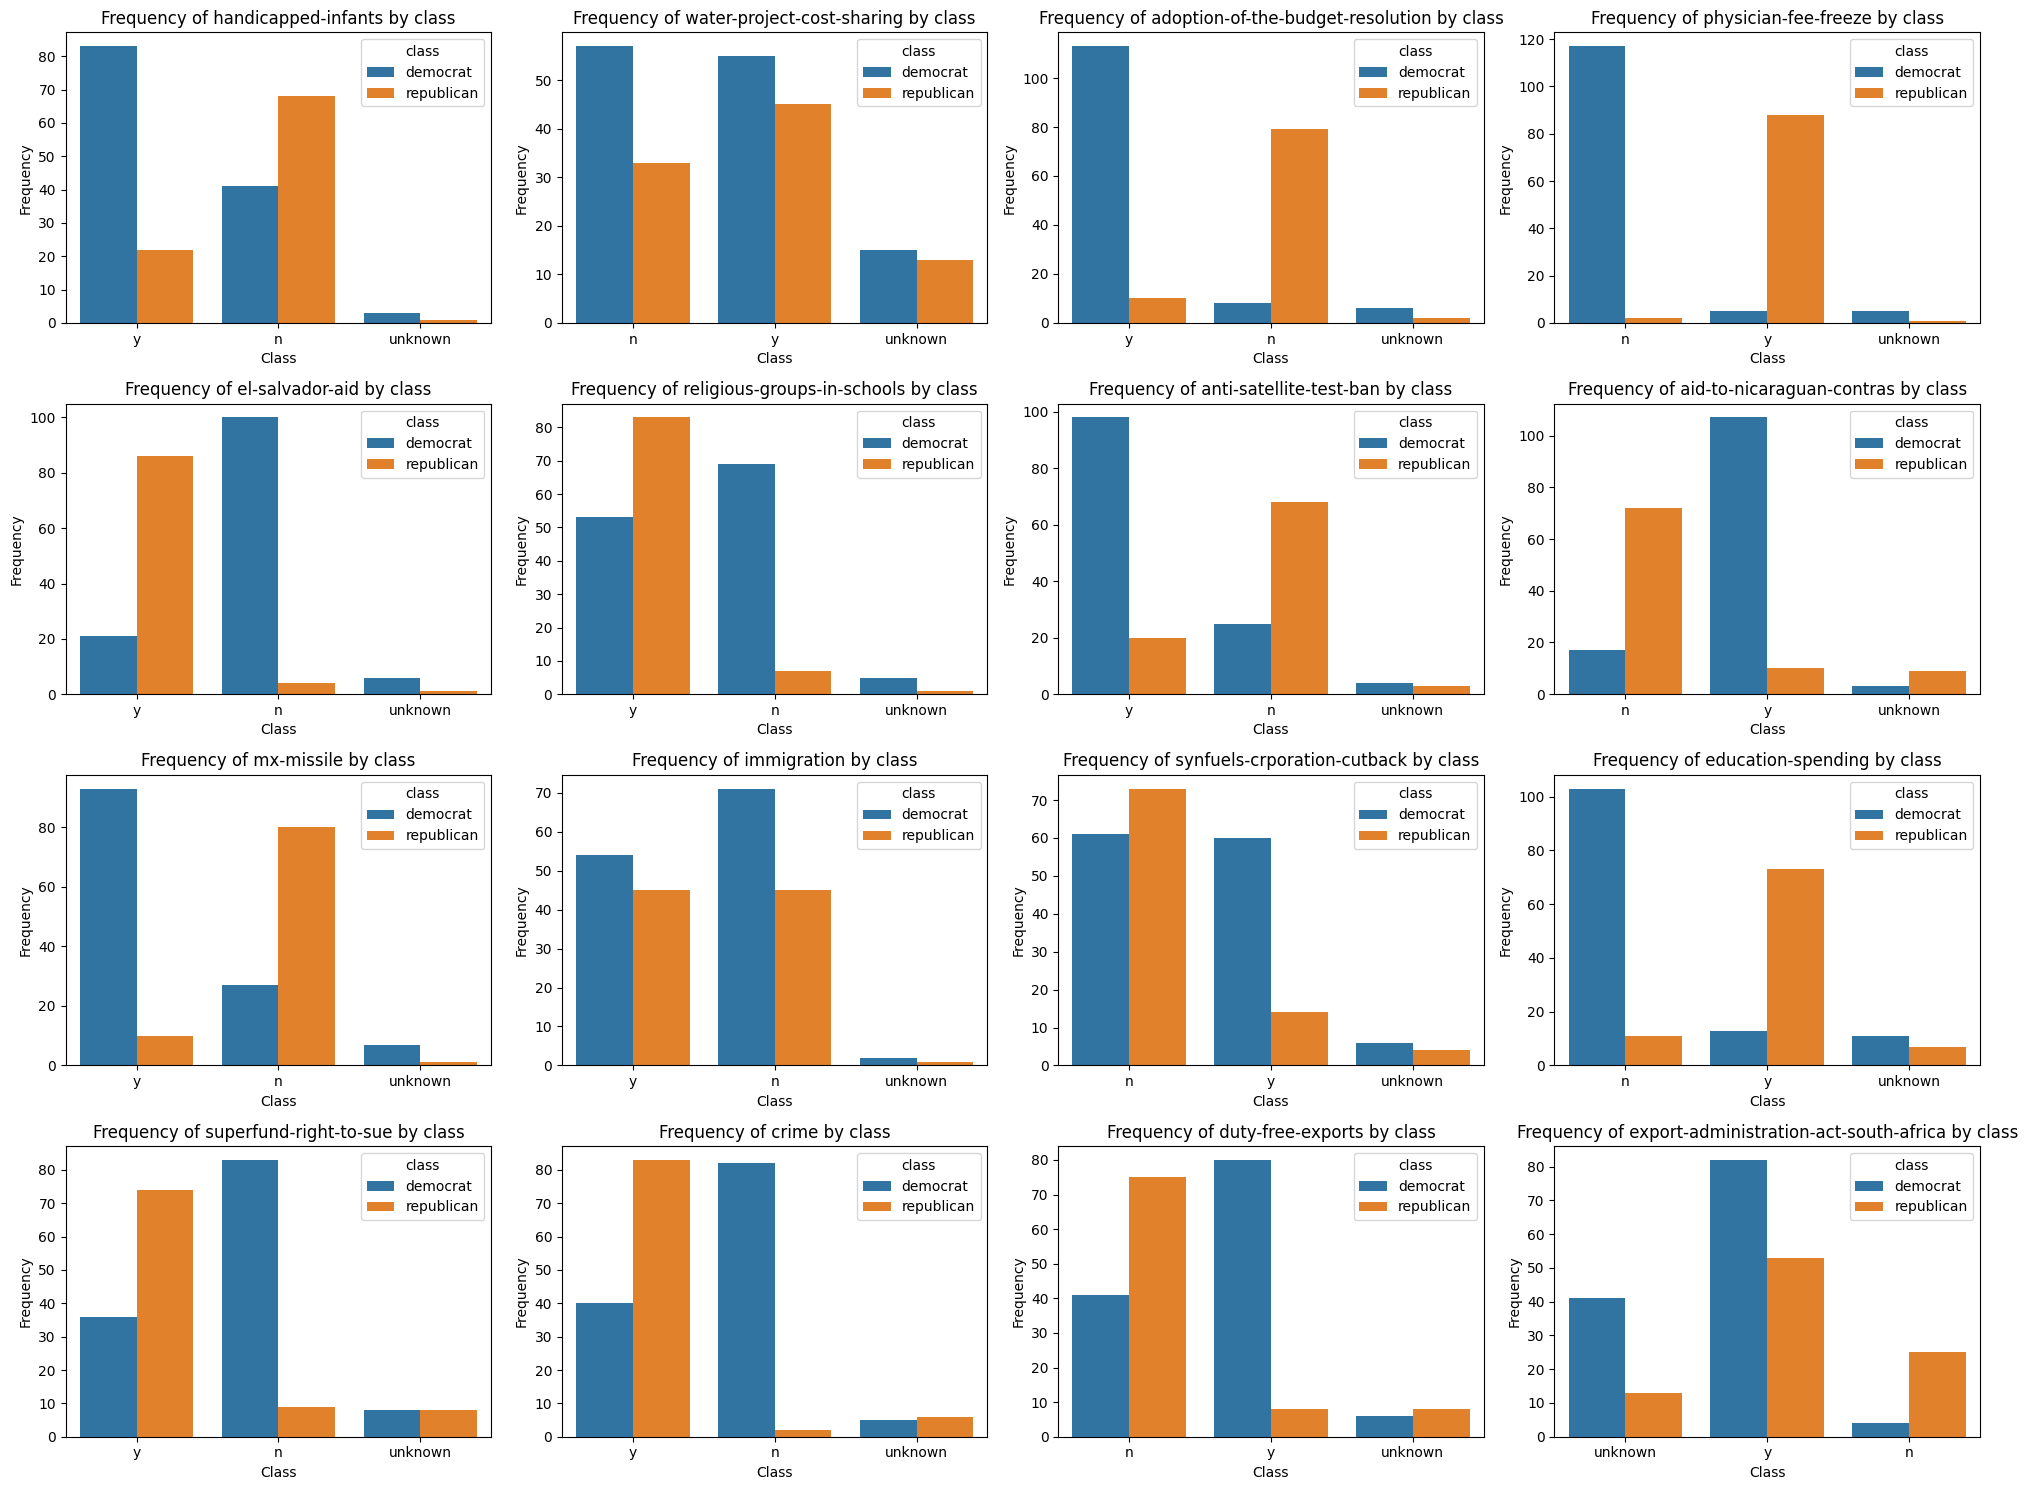

In [78]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()

for j, i in enumerate(df_voting.columns[2:]):  # Limits to 16 columns
    contingency_table = pd.crosstab(index=df_voting['class'], columns=df_voting[i], margins=True)
    display(contingency_table)
    
    sns.countplot(x=i, hue='class', data=df_voting, ax=axes[j])
    axes[j].set_title(f'Frequency of {i} by class')
    axes[j].set_xlabel('Class')
    axes[j].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

From the contingency tables we can get a grasp which attributes might indicate the best how an answer to a specific question could predict the class of the voter. For example adoption-of-the-budget-resolution was highly answered with "no" by republicans and "yes" by democrats while physician-fee-freeze was highly answered with "no" by democrats and "yes by republicans. Some questions are nearly balanced out and are harder to determine if the voter is going to vote democrat or republican. E.g. synfuels-crporation-cutback.

## Pre processing

We want to use for our data sets these three clasifiers:
1. Random Forrests
2. Support Vector Machines
3. Multilayer Perceptron

The classifier 1. could handle our missing value 'unknown' but for the classifiers 2. and 3. we need fully numeric data. So we change democrat to 0 and republican to 1 and n to 0, y to 1. In the next step we choose how to handle the missing value.

In [79]:
df_voting = df_voting.replace("democrat", 0).replace("republican", 1)
df_voting = df_voting.replace("n", 0).replace("y", 1)

display(df_voting)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1,0,1,0,1,1,1,0,1,1,0,0,1,1,0,unknown
1,86,0,0,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1
2,264,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,unknown
3,258,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,unknown,1
4,381,0,1,1,1,0,0,1,unknown,1,1,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,209,0,0,0,1,0,0,0,1,1,1,0,0,unknown,0,0,1,1
214,184,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown
215,309,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0
216,348,1,1,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0



### Handeling missing values

We will try different versions:

- keep the missing values as category
- impute missing values with median
- impute missing values with MICE

ID                                         0
class                                      0
handicapped-infants                        4
water-project-cost-sharing                28
adoption-of-the-budget-resolution          8
physician-fee-freeze                       6
el-salvador-aid                            7
religious-groups-in-schools                6
anti-satellite-test-ban                    7
aid-to-nicaraguan-contras                 12
mx-missile                                 8
immigration                                3
synfuels-crporation-cutback               10
education-spending                        18
superfund-right-to-sue                    16
crime                                     11
duty-free-exports                         14
export-administration-act-south-africa    54
dtype: int64

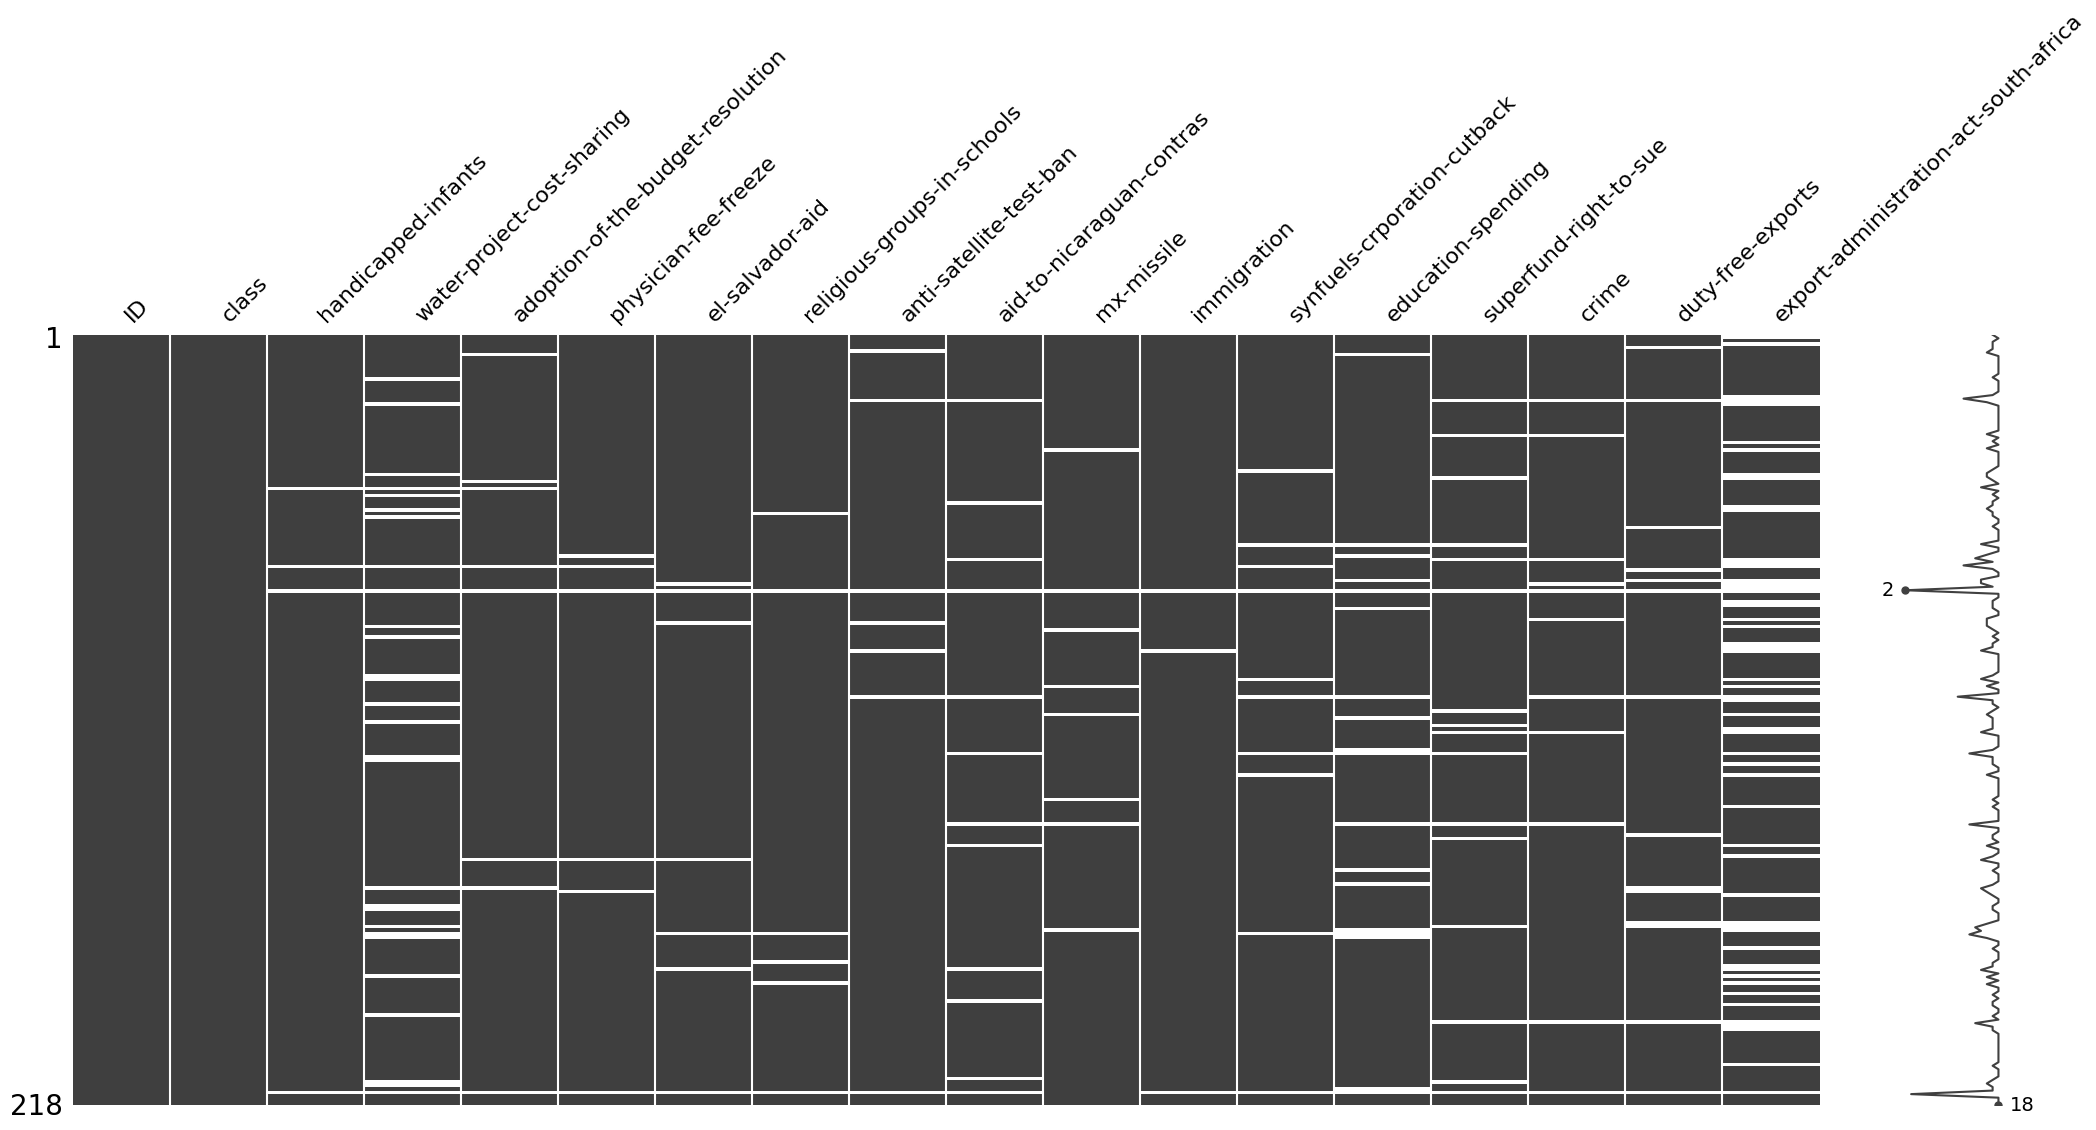

In [80]:
df_voting = df_voting.replace("unknown", np.nan)

msno.matrix(df_voting)
df_voting.isna().sum()

There are some rows where we have in nearly all columns a missing value so we will delete these rows. We have a lot of missing values in the last column but not more than half so lets keep the column.

In [81]:
missing_values = df_voting.isnull().sum(axis=1)

df_voting = df_voting.drop(missing_values[missing_values > 10].index)

In [82]:
df_voting_keep_unknown = df_voting.replace(np.nan, 2)

df_voting_impute_median = df_voting.fillna(df_voting.median())

# use mice to impute missing values
imputer = IterativeImputer(max_iter = 25)
imputer.fit(df_voting.loc[:, df_voting.columns[2:]])
df_imputer = imputer.transform(df_voting.loc[:, df_voting.columns[2:]])
df_voting_impute_mice = df_voting.copy()
df_voting_impute_mice.loc[:, df_voting.columns[2:]] = df_imputer

display(df_voting)
display(df_voting_keep_unknown)
display(df_voting_impute_median)
display(df_voting_impute_mice)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN
1,86,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,264,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,258,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0
4,381,0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,377,0,1.0,NaN,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
213,209,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0
215,309,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
216,348,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0
1,86,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,264,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,258,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0
4,381,0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,377,0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
213,209,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0
215,309,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
216,348,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,86,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,264,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,258,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,381,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,377,0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
213,209,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
215,309,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
216,348,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1.0,0.000000,1.0,0.0,1.0,1.0,1.000000,0.0,1.0,1.0,0.0,0.000000,1.0,1.0,0.000000,0.902273
1,86,0,0.0,0.000000,1.0,0.0,1.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,0.000000,1.000000
2,264,0,1.0,0.000000,1.0,0.0,0.0,0.0,1.000000,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.996281
3,258,1,0.0,0.000000,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.265008,1.000000
4,381,0,1.0,1.000000,1.0,0.0,0.0,1.0,0.813926,1.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,377,0,1.0,0.543015,1.0,0.0,0.0,0.0,1.000000,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.000000,1.000000
213,209,0,0.0,0.000000,1.0,0.0,0.0,0.0,1.000000,1.0,1.0,0.0,0.0,0.077362,0.0,0.0,1.000000,1.000000
215,309,1,0.0,0.000000,0.0,1.0,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,1.000000,1.0,1.0,0.000000,0.000000
216,348,1,1.0,0.000000,0.0,1.0,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,1.000000,1.0,1.0,0.000000,0.000000


Multiple Imputation by Chained Equations (MICE) is a method of dealing with missing data in datasets. The procedure imputes missing data in a dataset through an iterative series of predictive models. In each iteration, each specified variable in the dataset is imputed using the other variables in the datase.

<AxesSubplot:>

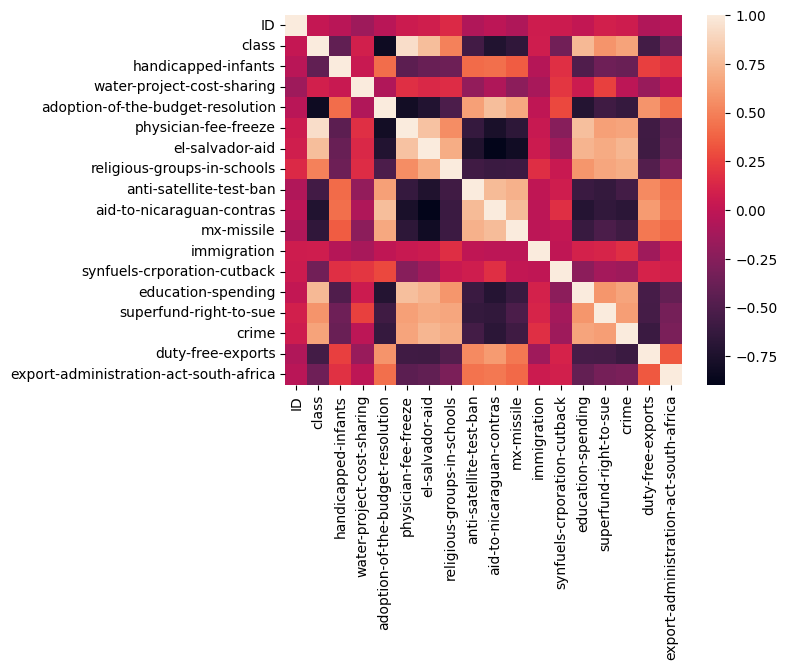

In [83]:
corr = df_voting.corr(method='pearson', numeric_only=True)
sns.heatmap(corr)

### Outliers

In [84]:
def outliers(data):
  numeric_columns = data.select_dtypes(include='number').columns
  # Identify outliers using the IQR method
  Q1 = data[numeric_columns].quantile(0.25)
  Q3 = data[numeric_columns].quantile(0.75)
  IQR = Q3 - Q1
  # Step 3: Identifying outliers
  outlier_info = {}  # Dictionary to hold outlier information

  for column in numeric_columns:
      outlier_condition = (data[column] < (Q1[column] - 1.5 * IQR[column])) | \
                          (data[column] > (Q3[column] + 1.5 * IQR[column]))
    
      # If there are any outliers for the current column
      if outlier_condition.any():
          outlier_indices = data[outlier_condition].index.tolist()  # Get the indices of outliers
          outlier_values = data.loc[outlier_condition, column].values.tolist()  # Get the outlier values
          outlier_info[column] = {'indices': outlier_indices, 'values': outlier_values}

  # Step 4: Print outlier information
  print("\n eventual outliers Found in Each Column:")

  # Summary of the number of outliers per column
  print("\nSummary of Outliers by Column:")
  for column, info in outlier_info.items():
      print(f"Column '{column}' has {len(info['indices'])} outliers.")

outliers(df_voting_keep_unknown)
outliers(df_voting_impute_median)
outliers(df_voting_impute_mice)


 eventual outliers Found in Each Column:

Summary of Outliers by Column:
Column 'export-administration-act-south-africa' has 81 outliers.

 eventual outliers Found in Each Column:

Summary of Outliers by Column:
Column 'export-administration-act-south-africa' has 29 outliers.

 eventual outliers Found in Each Column:

Summary of Outliers by Column:
Column 'export-administration-act-south-africa' has 61 outliers.


We have the fewest outliers for the imputation with the median. We also see that all our outliers are from the last column so maybe the best idea was to remove the column but maybe just for our data sets with keeping the missing values as a category and for the imputation with mice. Or we try to we use the technique that the outlier is capped at a certain value above the 90th percentile value or floored at a factor below the 10th percentile value.

We will try one where we just get rid of the last column for df_voting_keep_unknown. And use the Capping technique for mice for the last column. And for median we try one time with capping and one time where we will keep the outliers.

In [85]:
# drop the column with the most outliers for df_voting_keep_unknown
df_voting_keep_unknown = df_voting_keep_unknown.drop(columns=['export-administration-act-south-africa'])

# Quantile Based Flooring and Capping for the last column
def outliers_capping(data):
    numeric_columns = data.select_dtypes(include='number').columns
    # Identify outliers using the IQR method
    Q1 = data[numeric_columns].quantile(0.25)
    Q3 = data[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    # Step 3: Identifying outliers
    outlier_info = {}  # Dictionary to hold outlier information

    for column in numeric_columns:
        lower_bound = Q1[column] - 1.5 * IQR[column]
        upper_bound = Q3[column] + 1.5 * IQR[column]
        # Capping
        data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
    
    return data

df_voting_impute_median_keep_outliers = df_voting_impute_median

df_voting_impute_median_no_outliers = outliers_capping(df_voting_impute_median)
        
df_voting_impute_mice = outliers_capping(df_voting_impute_mice)

## Classification

For training our classification models we will first have to split our data into training and testing data.

As well we define a function for all models that returns the confusion matrix and classification report.

### Train-Test Split for every data set

This function will create a train test split for our different data sets.

In [107]:
def create_train_test(data):
    X_voting = data.drop(columns=['class'])
    y_voting = data['class']
    return train_test_split(X_voting, y_voting, random_state=104, test_size=0.25, shuffle=True, stratify=y_voting)

#X_voting_train, X_voting_test, y_voting_train, y_voting_test = create_train_test(df_voting)
#X_voting_train, X_voting_test, y_voting_train, y_voting_test = create_train_test(df_voting_keep_unknown)
X_voting_train, X_voting_test, y_voting_train, y_voting_test = create_train_test(df_voting_impute_median_keep_outliers)
#X_voting_train, X_voting_test, y_voting_train, y_voting_test = create_train_test(df_voting_impute_median_no_outliers)
#X_voting_train, X_voting_test, y_voting_train, y_voting_test = create_train_test(df_voting_impute_mice)
  

Scaling is not really necessary for this data set so we skip it.

This function will create the confusion matrix and classification report for our different data sets.

In [108]:
def evaluate_classification(model, X_test, y_test):
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy * 100))
    print('Classification Report:')
    print(classification_report(y_test, predictions, zero_division=1))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    
    return accuracy

## Classifier 1. Random Forest

### Hyperparameter tuning using grid search

This will help us find good parameters for our classifier.

In [109]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf_model = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_model.fit(X_voting_train, y_voting_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   2.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Try different parameter combinations

In [89]:
random_1 = RandomForestClassifier(n_estimators = 1000, max_features = 'log2', max_depth = 500, min_samples_split = 200, min_samples_leaf = 200, bootstrap = False)
random_1.fit(X_voting_train, y_voting_train)

random_2 = RandomForestClassifier(n_estimators = 800, max_features = 'sqrt', max_depth = 65, min_samples_leaf = 30, bootstrap = True, criterion='log_loss')
random_2.fit(X_voting_train, y_voting_train)

RandomForestClassifier(criterion='log_loss', max_depth=65, min_samples_leaf=30,
                       n_estimators=800)

## Classifier 2. Support Vector Machines

In [99]:
params_grid_svm = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
    {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 10, 100, 1000]}
]

svm_model = GridSearchCV(SVC(), params_grid_svm, cv=5)
svm_model.fit(X_voting_train, y_voting_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3],
                          'kernel': ['poly']}])

### Try different parameter combinations

## Classifier 3. Multilayer Percepton

In [100]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (10,20,20,25)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.1, 0.5],
    'max_iter': [2000, 2500, 3000, 4000, 5000],
    'learning_rate': ['constant','adaptive'],
}

mlp_model = RandomizedSearchCV(MLPClassifier(), param_distributions=param_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
mlp_model.fit(X_voting_train, y_voting_train)

RandomizedSearchCV(cv=3, estimator=MLPClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.05, 0.1, 0.5],
                                        'hidden_layer_sizes': [(50, 50, 50),
                                                               (50, 100, 50),
                                                               (100,),
                                                               (10, 20, 20,
                                                                25)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'max_iter': [2000, 2500, 3000, 4000,
                                                     5000],
                                        'solver': ['sgd', 'adam']},
                   random_state=42)

### Try different parameter combinations

## Evaluation

### Random Forest

In [98]:
final_rf_model = rf_model.best_estimator_
evaluate_classification(final_rf_model, X_voting_test, y_voting_test)

Model Performance
Accuracy = 96.49%.
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.96      0.96      0.96        23

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57

Confusion Matrix:
[[33  1]
 [ 1 22]]


0.9649122807017544

Results from different Pre-processing steps to see which performs best:

- model without pre-processing steps

Accuracy: 0.9649122807017544

- model with unknown as category

Accuracy: 0.9649122807017544

- model with median imputation with outliers

Accuracy:

- model with median imputation and outlier capping

Accuracy:

- model with mice imputation and outlier capping

In [91]:
final_rf_model = rf_model.best_estimator_

random_1_accuracy = evaluate_classification(random_1, X_voting_test, y_voting_test)
random_2_accuracy = evaluate_classification(random_2, X_voting_test, y_voting_test)
best_accuracy = evaluate_classification(final_rf_model, X_voting_test, y_voting_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_2_accuracy - random_1_accuracy) / random_1_accuracy))
print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - random_2_accuracy) / random_2_accuracy))

Model Performance
Accuracy = 59.65%.
Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        34
           1       1.00      0.00      0.00        23

    accuracy                           0.60        57
   macro avg       0.80      0.50      0.37        57
weighted avg       0.76      0.60      0.45        57

Confusion Matrix:
[[34  0]
 [23  0]]
Model Performance
Accuracy = 98.25%.
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      0.96      0.98        23

    accuracy                           0.98        57
   macro avg       0.99      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57

Confusion Matrix:
[[34  0]
 [ 1 22]]
Model Performance
Accuracy = 96.49%.
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97    

Results from different Parameter combinations

- 


-


-

### SVM

In [102]:
final_svm_model = svm_model.best_estimator_

evaluate_classification(final_svm_model, X_voting_test, y_voting_test)

Model Performance
Accuracy = 94.74%.
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

Confusion Matrix:
[[34  0]
 [ 3 20]]


0.9473684210526315

Results from different Pre-processing steps to see which performs best:

- model without pre-processing steps

Not possible for svm because of the missing value NaN

- model with unknown as category

Accuracy: 0.9473684210526315

- model with median imputation with outliers

Accuracy:

- model with median imputation and outlier capping

Accuracy:

- model with mice imputation and outlier capping

Results from different Parameter combinations

- 


-


-

In [103]:
final_mlp_model = mlp_model.best_estimator_

evaluate_classification(final_mlp_model, X_voting_test, y_voting_test)

Model Performance
Accuracy = 96.49%.
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       1.00      0.91      0.95        23

    accuracy                           0.96        57
   macro avg       0.97      0.96      0.96        57
weighted avg       0.97      0.96      0.96        57

Confusion Matrix:
[[34  0]
 [ 2 21]]


0.9649122807017544

Results from different Pre-processing steps to see which performs best:

- model without pre-processing steps

Not possible for mlp because of the missing value NaN

- model with unknown as category

Accuracy: 0.9649122807017544

- model with median imputation with outliers

Accuracy:

- model with median imputation and outlier capping

Accuracy:

- model with mice imputation and outlier capping

Results from different Parameter combinations

- 


-


-

### Prediction for Kaggle Copetition

In [420]:
df_voting_test = df_voting_test.replace("n", 0).replace("y", 1).replace("unknown", np.nan)

df_predictions = mlp_model.predict(df_voting_test)

df_predictions = pd.DataFrame(df_predictions, index=df_voting_test['ID'].astype(int), columns=['class'])

df_predictions = df_predictions.replace(0, "democrat").replace(1, "republican")

# Save the DataFrame to a CSV file
df_predictions.to_csv('data/predictions.csv')

Best Prediction:



Worst Prediction: